# Gate Cutting to Reduce Circuit Depth

In this tutorial, we will simulate some expectation values on a circuit of a certain depth by cutting gates resulting in swap gates and executing subexperiments on shallower circuits.

Like any circuit knitting technique, gate cutting can be described as three consecutive steps:

- **decompose** some non-local gates in the circuit and possibly separate the circuit into subcircuits
- **execute** many sampled subexperiments using the Qiskit Sampler primitive
- **reconstruct** the expectation value of the full-sized circuit

### Create a circuit to run on the backend

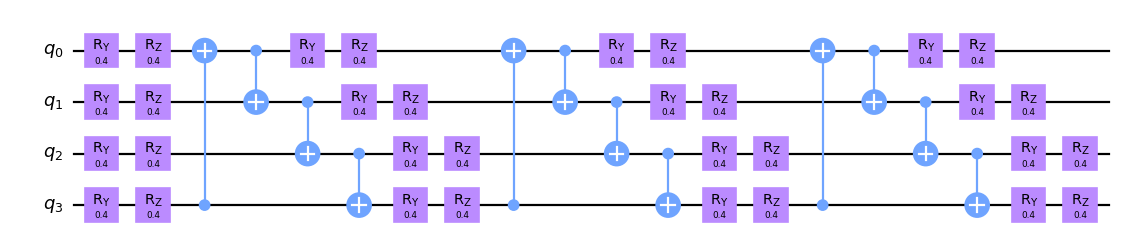

In [1]:
from qiskit.circuit.library import EfficientSU2

circuit = EfficientSU2(num_qubits=4, entanglement="circular").decompose()
circuit.assign_parameters([0.4] * len(circuit.parameters), inplace=True)
circuit.draw("mpl", scale=0.8)

### Specify some observables

Currently, only `Pauli` observables with phase equal to 1 are supported. Full support for `SparsePauliOp` is expected in CKT v0.5.0.

In [2]:
from qiskit.quantum_info import PauliList

observables = PauliList(["ZZII", "IZZI", "IIZZ", "XIXI", "ZIZZ", "IXIX"])

### Transpile the circuit, visualize the swaps, and note the depth

We choose a layout that requires two swaps to execute the gates between qubits 3 and 0 and another two swaps to return the qubits to their initial positions.

In [3]:
from qiskit import transpile
from qiskit.providers.fake_provider import FakeHanoi

backend = FakeHanoi()

transpiled_qc = transpile(circuit, backend=backend, initial_layout=[0, 1, 2, 3])
print(f"Transpiled circuit depth: {transpiled_qc.depth()}")

Transpiled circuit depth: 63


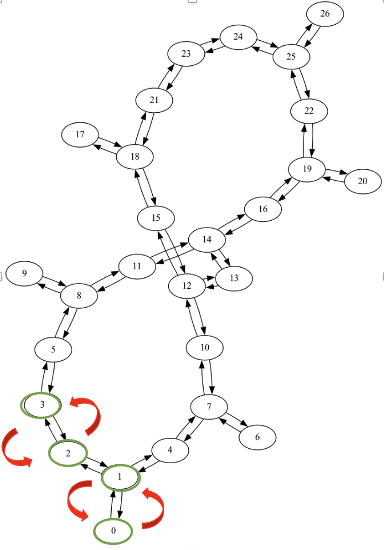

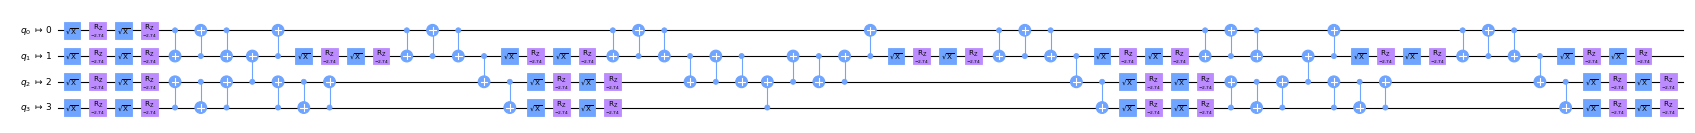

In [4]:
transpiled_qc.draw("mpl", scale=0.4, idle_wires=False, fold=-1)

### Replace distant gates with `TwoQubitQPDGate`s by specifying their indices

`cut_gates` will replace the gates in the specified indices with `TwoQubitQPDGate`s and also return a list of `QPDBasis` instances -- one for each gate decomposition.

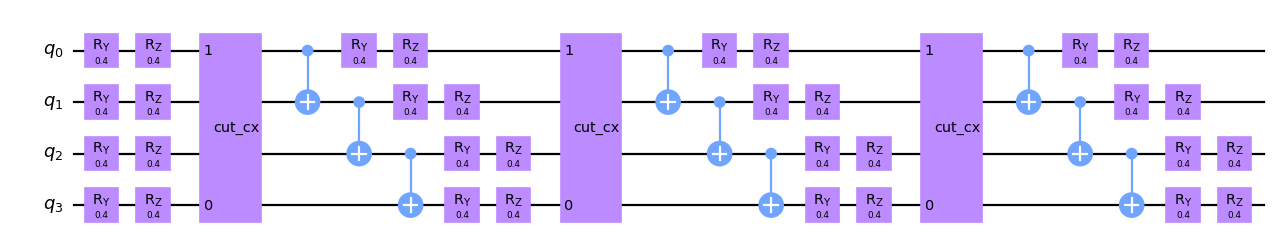

In [5]:
from circuit_knitting.cutting import cut_gates

# Find the indices of the distant gates
cut_indices = [
    i
    for i, instruction in enumerate(circuit.data)
    if {circuit.find_bit(q)[0] for q in instruction.qubits} == {0, 3}
]

# Decompose distant CNOTs into TwoQubitQPDGate instances
qpd_circuit, bases = cut_gates(circuit, cut_indices)

qpd_circuit.draw("mpl", scale=0.8)

### Generate the subexperiments to run on the backend

`generate_cutting_experiments` accepts a circuit containing `TwoQubitQPDGate` instances and observables as a `PauliList`.

To simulate the expectation value of the full-sized circuit, many subexperiments are generated from the decomposed gates' joint quasiprobability distribution and then executed on one or more backends. The number of samples taken from the distribution is controlled by `num_samples`, and one combined weight is given for each unique sample. For more information on how the weights are calculated, refer to the [explanatory material](../explanation/index.rst).

In [6]:
import numpy as np
from circuit_knitting.cutting import generate_cutting_experiments

# Generate the subexperiments and sampling weights
subexperiments, weights = generate_cutting_experiments(
    circuits=qpd_circuit, observables=observables, num_samples=np.inf
)

### Calculate the sampling overhead for the chosen cuts

Here we cut three CNOT gates, resulting in a sampling overhead of $9^3$.

For more on the sampling overhead incurred by circuit cutting, refer to the [explanatory material](../explanation/index.rst).

In [7]:
print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")

Sampling overhead: 729.0


### Demonstrate that the QPD subexperiments will be shallower after cutting distant gates

Here is an example of an arbitrarily chosen subexperiment generated from the QPD circuit. Its depth has been reduced by more than half. Many of these probabilistic subexperiments must be generated and evaluated in order to reconstruct an expectation value of the deeper circuit.

Original circuit depth after transpile: 63
QPD subexperiment depth after transpile: 26


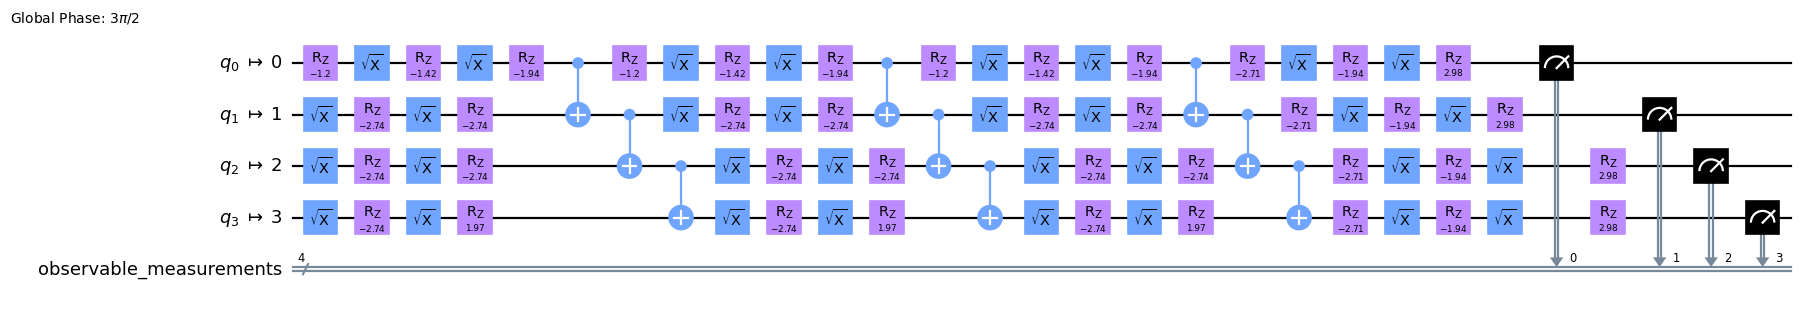

In [8]:
# Transpile the decomposed circuit to the same layout
transpiled_qpd_circuit = transpile(
    subexperiments[0], backend=backend, initial_layout=[0, 1, 2, 3]
)

print(f"Original circuit depth after transpile: {transpiled_qc.depth()}")
print(f"QPD subexperiment depth after transpile: {transpiled_qpd_circuit.depth()}")
transpiled_qpd_circuit.draw("mpl", scale=0.8, idle_wires=False, fold=-1)

### Run the subexperiments using the Qiskit Sampler primitive

In [9]:
from qiskit_aer.primitives import Sampler

# Set up Qiskit Aer Sampler primitive.
sampler = Sampler(run_options={"shots": 2**12})

# Retrieve results from each subexperiment
results = sampler.run(subexperiments).result()

To use the Qiskit Runtime Sampler, replace the code above with this commented block.

In [10]:
# from qiskit_ibm_runtime import Session, Options, Sampler

# with Session(backend="ibmq_qasm_simulator") as session:
#    options = Options()
#    options.execution.shots = 2**12
#    sampler = Sampler(options=options)

#    results = sampler.run(subexperiments).result()

#    session.close()

### Reconstruct the expectation values

Use the subexperiment results, subobservables, and sampling weights to reconstruct the expectation value of the original circuit.

Include the number of bits used for cutting measurements in the results metadata. This will be automated in a future release, but users must specify it manually for now.

In [11]:
from circuit_knitting.cutting import reconstruct_expectation_values

for i in range(len(subexperiments)):
    results.metadata[i]["num_qpd_bits"] = len(subexperiments[i].cregs[0])

reconstructed_expvals = reconstruct_expectation_values(
    results,
    weights,
    observables,
)

### Compare reconstructed expectation values to exact expectation values from the original circuit

In [12]:
from qiskit_aer.primitives import Estimator

estimator = Estimator(run_options={"shots": None}, approximation=True)
exact_expvals = (
    estimator.run([circuit] * len(observables), list(observables)).result().values
)
print(
    f"Reconstructed expectation values: {[np.round(reconstructed_expvals[i], 8) for i in range(len(exact_expvals))]}"
)
print(
    f"Exact expectation values: {[np.round(exact_expvals[i], 8) for i in range(len(exact_expvals))]}"
)
print(
    f"Errors in estimation: {[np.round(reconstructed_expvals[i]-exact_expvals[i], 8) for i in range(len(exact_expvals))]}"
)
print(
    f"Relative errors in estimation: {[np.round((reconstructed_expvals[i]-exact_expvals[i]) / exact_expvals[i], 8) for i in range(len(exact_expvals))]}"
)

Reconstructed expectation values: [0.46270752, 0.54742432, 0.36254883, -0.24908447, 0.29718018, -0.23010254]
Exact expectation values: [0.50983039, 0.56127511, 0.36167086, -0.23006544, 0.23416169, -0.20855487]
Errors in estimation: [-0.04712287, -0.0138508, 0.00087797, -0.01901904, 0.06301848, -0.02154767]
Relative errors in estimation: [-0.09242853, -0.02467738, 0.00242753, 0.08266794, 0.26912379, 0.10331893]


In [13]:
import qiskit.tools.jupyter  # noqa: F401

%qiskit_version_table